<a href="https://colab.research.google.com/github/sridevibonthu/Qualifying/blob/master/Model_with_separable_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!unzip -q "/content/gdrive/My Drive/Assignment5/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

gdrive/  hvc_annotations.csv  resized/  sample_data/


In [3]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers.convolutional import SeparableConvolution2D,Convolution2D, MaxPooling2D, SeparableConvolution2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [4]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [5]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

In [0]:
class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, train_mean, train_std, batch_size=32, shuffle=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.train_mean = train_mean
        self.train_std = train_std
        #self.val = val
       # self.eraser=get_random_eraser()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        images = []
        for image in [cv2.imread(item["image_path"]) for _, item in items.iterrows()]:
          # normalize mean of 0 and stdev of 1
          image = ((image-self.train_mean)/self.train_std).astype('float32') 

         # if not self.val:
          #  image = self.eraser(image)
            #image = tf.image.random_flip_left_right(image)
          
          images.append(image)

        images = np.stack(images, axis=0)

        #image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        target= {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        
        return images, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [8]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.2, random_state=42)
train_df.shape, val_df.shape

((10858, 28), (2715, 28))

In [9]:
from tqdm import tnrange, tqdm_notebook
n = 0
s = np.zeros(3)
sq = np.zeros(3)
y = None
for _, item in tqdm_notebook(train_df.iterrows()):
  x = cv2.imread(item["image_path"]).astype('double')
  s += np.sum(x, axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]
  y = x

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))

print(mu, std, n)


[41.34606735 41.56142807 46.62353164] [63.99020204 64.62708368 69.80721893] 544811008


In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, mu, std, batch_size=32)
valid_gen = PersonDataGenerator(val_df, mu, std, batch_size=64, shuffle=False)

In [11]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
def subpart(model):
  model.add(SeparableConvolution2D(512, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(SeparableConvolution2D(512, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(SeparableConvolution2D(512, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2),  strides=(2, 2)))
  model.add(Dropout(0.25))
  return model

In [0]:
def myModel(input_shape=(224,224,3)):
  model=Sequential()
  model.add(SeparableConvolution2D(64, (3, 3), padding='same', input_shape=input_shape, name='B1_C1'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(SeparableConvolution2D(64, (3, 3), padding='same', name='B1_C2'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2),  strides=(2, 2)))
  model.add(Dropout(0.25))

  model.add(SeparableConvolution2D(128, (3, 3), padding='same', name='B2_C1'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(SeparableConvolution2D(128, (3, 3), padding='same', name='B2_C2'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2),  strides=(2, 2)))
  model.add(Dropout(0.25))

  model.add(SeparableConvolution2D(256, (3, 3), padding='same',name='B3_C1'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(SeparableConvolution2D(256, (3, 3), padding='same', name='B3_C2'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2),  strides=(2, 2)))
  model.add(Dropout(0.25))

  model = subpart(model)
  model = subpart(model)
  model.add(SeparableConvolution2D(512, (7, 7), activation='relu'))

  return model

In [14]:
backbone = myModel()
backbone.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
B1_C1 (SeparableConv2D)      (None, 224, 224, 64)      283       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
B1_C2 (SeparableConv2D)      (None, 224, 224, 64)      4736      
_________________________________________________________________
activation_2 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 224, 224, 64)      256 

In [0]:
neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))

age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))

bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))

emotion = build_head("emotion", build_tower(neck))

pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

In [16]:
print(backbone.input)

Tensor("B1_C1_input:0", shape=(?, 224, 224, 3), dtype=float32)


In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
B1_C1_input (InputLayer)        (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
B1_C1 (SeparableConv2D)         (None, 224, 224, 64) 283         B1_C1_input[0][0]                
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 64) 0           B1_C1[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 64) 256         activation_1[0][0]               
____________________________________________________________________________________________

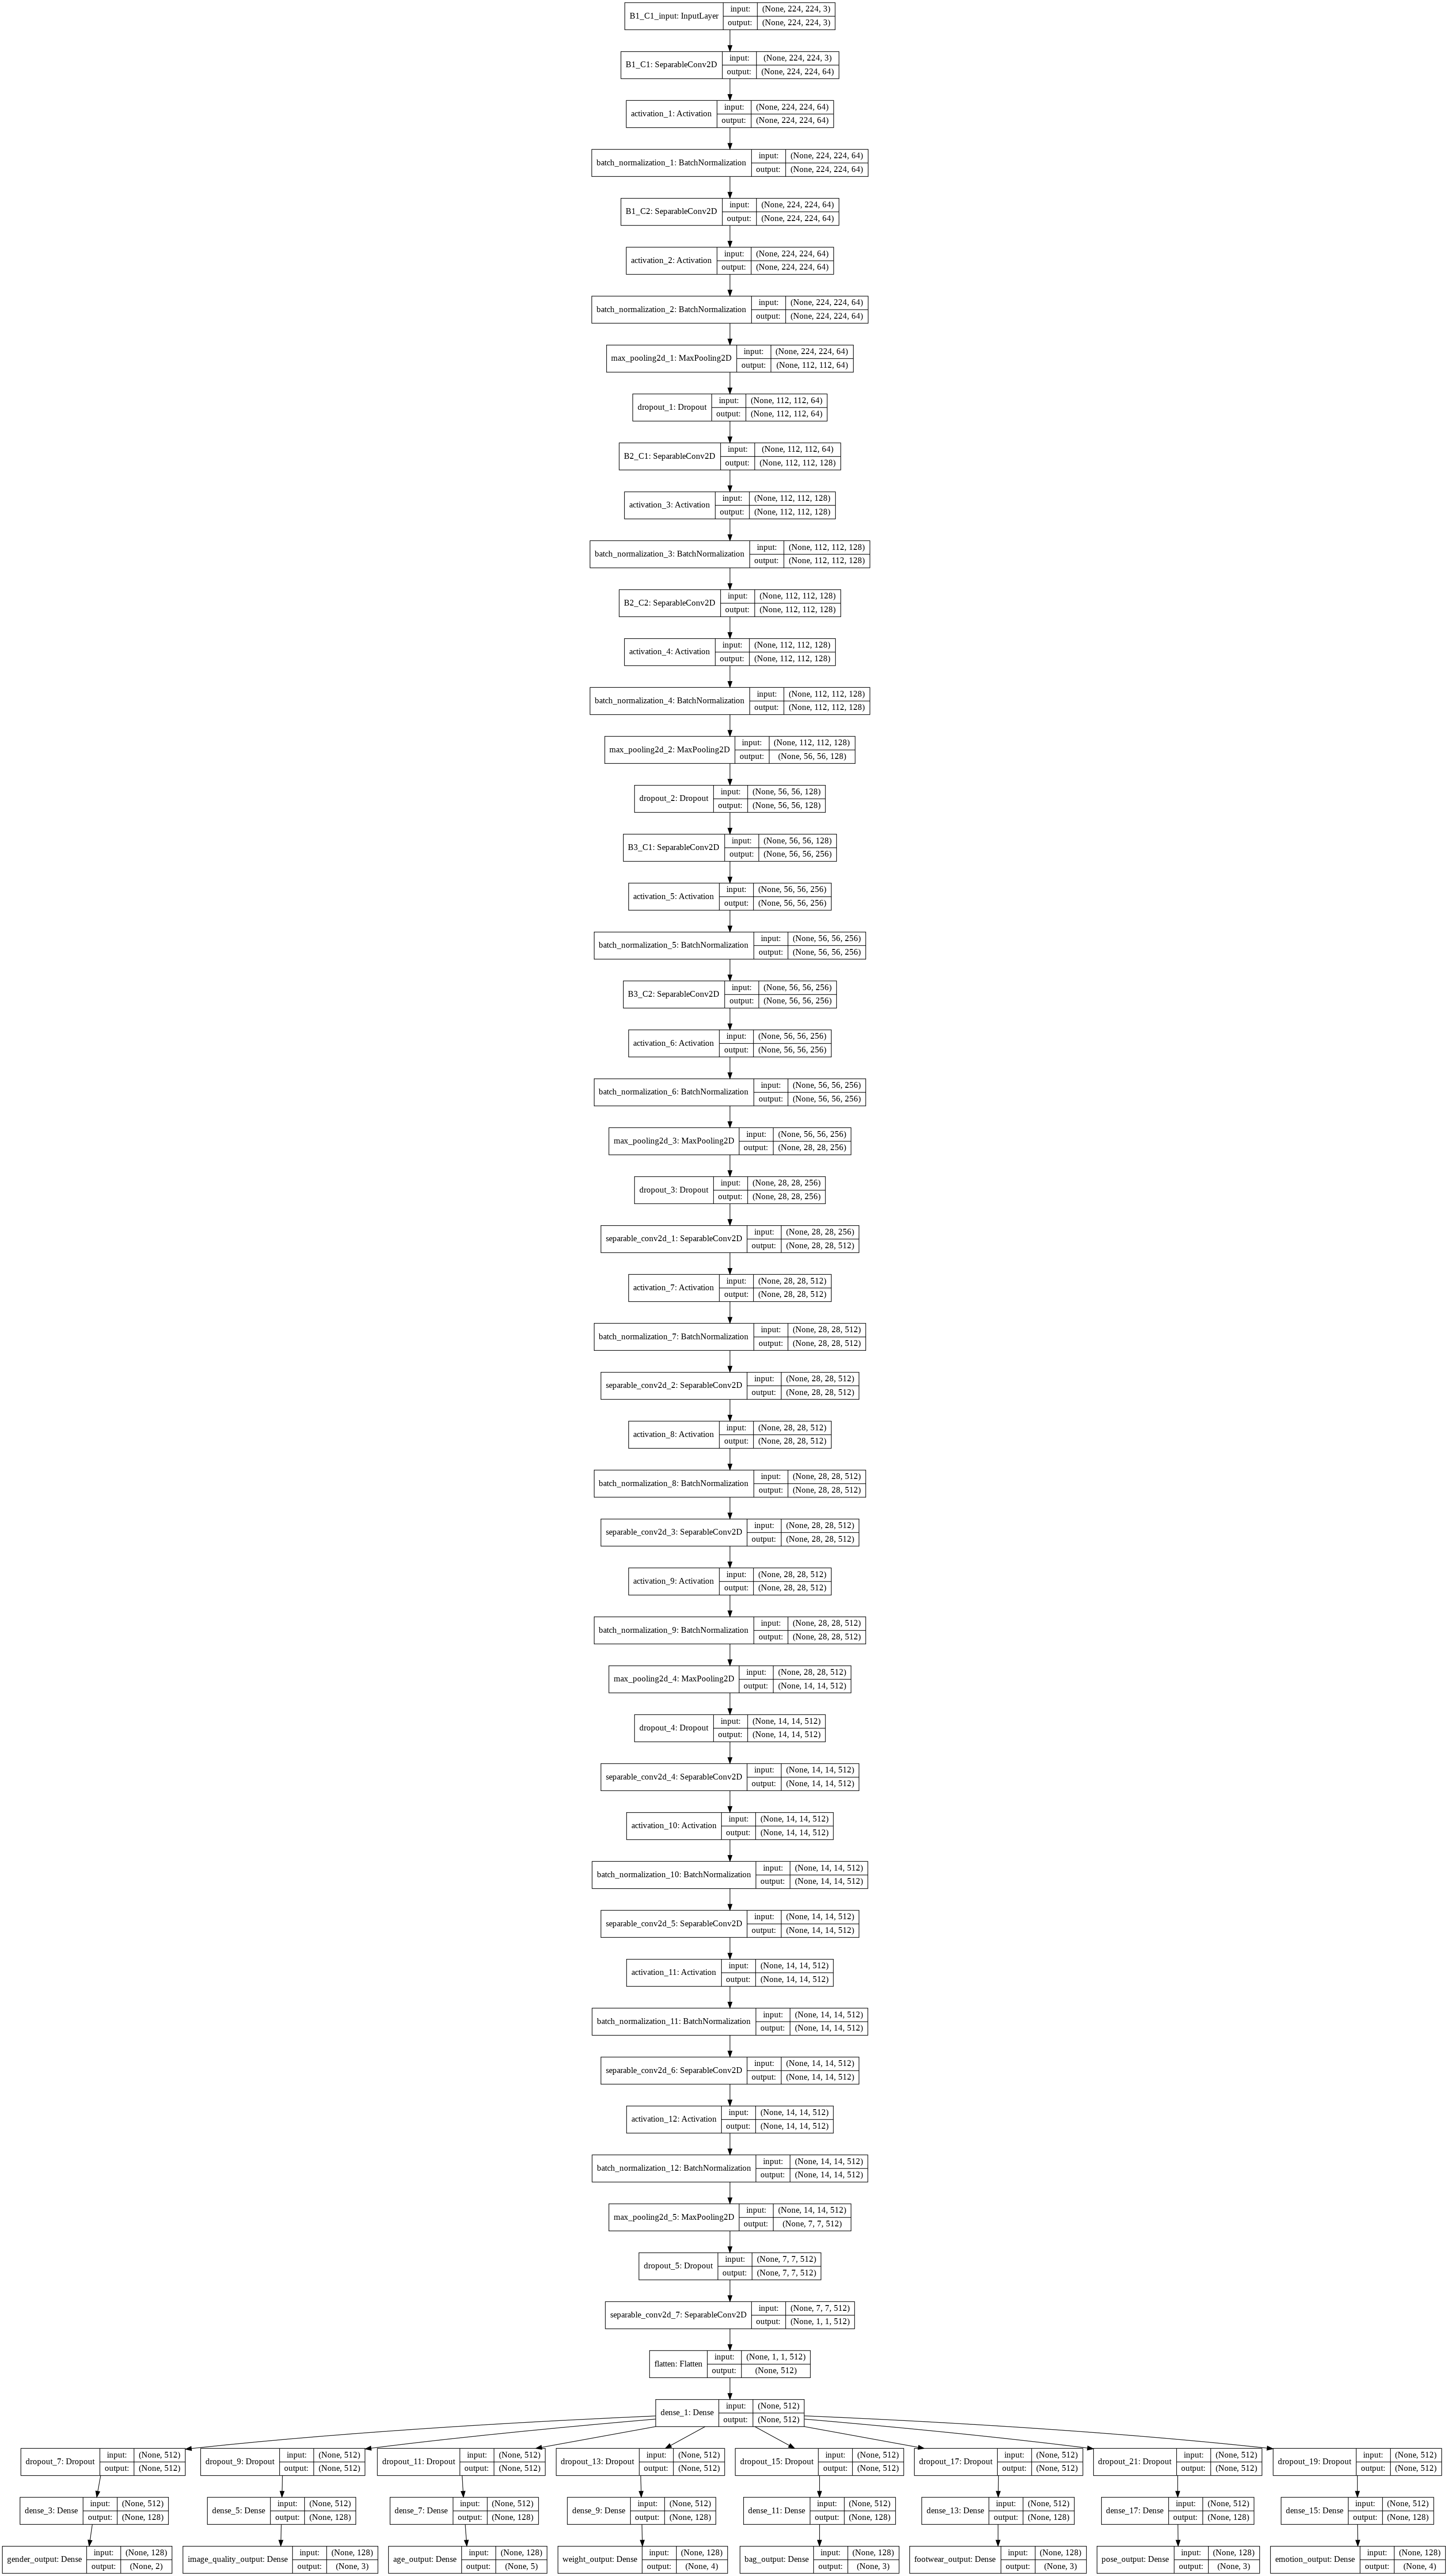

In [18]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [19]:
opt = SGD(lr=0.001, momentum=0.9)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [20]:
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=24,
    verbose=1,
    
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/24
339/339 [==============================] - 426s 1s/step - loss: 7.9665 - gender_output_loss: 0.6861 - image_quality_output_loss: 0.9690 - age_output_loss: 1.4499 - weight_output_loss: 1.0214 - bag_output_loss: 0.9336 - footwear_output_loss: 1.0172 - pose_output_loss: 0.9445 - emotion_output_loss: 0.9448 - gender_output_acc: 0.5523 - image_quality_output_acc: 0.5470 - age_output_acc: 0.3921 - weight_output_acc: 0.6254 - bag_output_acc: 0.5592 - footwear_output_acc: 0.4980 - pose_output_acc: 0.6140 - emotion_output_acc: 0.7004 - val_loss: 7.9272 - val_gender_output_loss: 0.6895 - val_image_quality_output_loss: 1.0578 - val_age_output_loss: 1.4321 - val_weight_output_loss: 0.9775 - val_bag_output_loss: 0.9139 - val_footwear_output_loss: 1.0098 - val_pose_output_loss: 0.9309 - val_emotion_output_loss: 0.9157 - val_gender_output_acc: 0.5525 - val_image_quality_output_acc: 0.5618 - val_

In [0]:
# create on Colab directory
model.save('model.h5')    


In [0]:
model.save_weights('model_weights.h5')


In [0]:
history=model.history

In [22]:
#print(history.history.keys())
for x in history.history.keys():
  if x.startswith('val') and x.endswith('acc'):
    print(x, " -- ",  history.history[x][-1])

val_gender_output_acc  --  0.8504464285714286
val_image_quality_output_acc  --  0.5714285714285714
val_age_output_acc  --  0.41443452380952384
val_weight_output_acc  --  0.6428571428571429
val_bag_output_acc  --  0.6499255952380952
val_footwear_output_acc  --  0.6648065476190477
val_pose_output_acc  --  0.7927827380952381
val_emotion_output_acc  --  0.7053571428571429


In [23]:
print('gender : ', max(history.history['val_gender_output_acc']))
print('image quality : ', max(history.history['val_image_quality_output_acc']))
print('age : ', max(history.history['val_age_output_acc']))
print('weight : ', max(history.history['val_weight_output_acc']))
print('bag : ', max(history.history['val_bag_output_acc']))
print('footwear : ', max(history.history['val_footwear_output_acc']))
print('pose : ', max(history.history['val_pose_output_acc']))
print('emotion : ', max(history.history['val_emotion_output_acc']))

gender :  0.8504464285714286
image quality :  0.5948660714285714
age :  0.41517857142857145
weight :  0.6465773809523809
bag :  0.6599702380952381
footwear :  0.6707589285714286
pose :  0.8087797619047619
emotion :  0.7083333333333334


In [0]:
history=model.history

In [25]:
val_loss=[]
for i in range(24):
  sum=0
  l = ['val_gender_output_loss','val_image_quality_output_loss',  'val_age_output_loss', 'val_weight_output_loss', 'val_bag_output_loss', 'val_footwear_output_loss', 'val_pose_output_loss',
 'val_emotion_output_loss']
  for x in l:
    sum += history.history[x][i]
  val_loss.append(sum)
print(val_loss)

[7.9272052219935825, 7.956884114515213, 7.611346724487486, 7.819989750782648, 7.917912612358729, 7.485683905226844, 7.102180569654419, 7.14346954936073, 6.9417866078161055, 6.880071898301443, 7.00693611516839, 6.721752048957916, 6.670972531395298, 6.645123738972915, 6.760839619097255, 6.573450069342341, 6.695753048928011, 6.576465563405128, 6.741436310112476, 6.478246266288417, 6.516444592248826, 6.6289762290460725, 6.5689731658924195, 6.629033693955058]


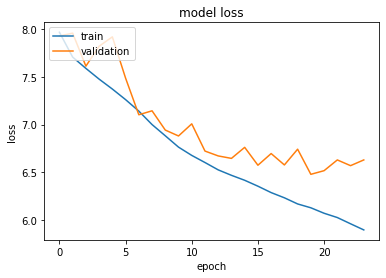

In [26]:
  import matplotlib.pyplot as plt
  plt.plot(history.history['loss'])
  plt.plot(val_loss)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()  #no reduction in validation loss

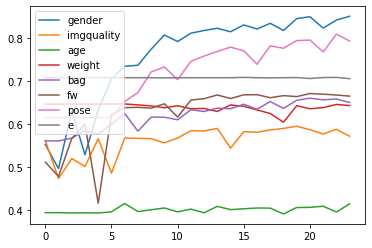

In [27]:
plt.plot(history.history['val_gender_output_acc'])
plt.plot(history.history['val_image_quality_output_acc'])
plt.plot(history.history['val_age_output_acc'])
plt.plot(history.history['val_weight_output_acc'])
plt.plot(history.history['val_bag_output_acc'])
plt.plot(history.history['val_footwear_output_acc'])
plt.plot(history.history['val_pose_output_acc'])
plt.plot(history.history['val_emotion_output_acc'])
plt.legend(['gender', 'imgquality','age','weight', 'bag','fw','pose','e'], loc='upper left')
plt.show()

In [0]:
from google.colab import drive
drive.mount('/content/drive')